In [1]:
import time

import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.io as pio

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}
pio.renderers.default = "png"
px.defaults.color_discrete_sequence = px.colors.qualitative.D3

%load_ext autoreload
%autoreload 2

# Input data
-----------------------------
We use [SimBench](https://simbench.de/en/download/datasets/) to obtain a representative low voltage network
We use the [Quoilin](https://github.com/squoilin/Self-Consumption/releases) database for household consumption in France
We use the [PVGIS](https://re.jrc.ec.europa.eu/pvg_tools/en/) database for solar irradiation in Lyon

In [2]:
import scenario

# Network, active profiles, reactive profiles, active net loads, battery specs
net, dfp, dfq, df, batteries = scenario.get_network_and_timeseries()

Max loading = 114.908
Transformator eq. impedance (secondary) = (0.015+0.037j) Ohm (x1).


# Pareto
---------------------------------

In [3]:
import logging

# Logging info
log_filename = "logs/tradeoff_collective_reduc.log"
logger = logging.getLogger("Tradeoff")
logger.setLevel('DEBUG')
file_handler = logging.FileHandler(log_filename, mode="w")
if not len(logger.handlers):
    logger.addHandler(file_handler)

In [4]:
import tradeoff
from datetime import timedelta

with open(log_filename, 'w'):
    pass

days = 2
starts = pd.date_range(datetime(2019, 1, 1, 5, 0, 0), periods=182, freq=f"{days}D")  # 121
durations = [slice(start, start + timedelta(days=days) - timedelta(minutes=15)) for start in starts]
assert durations[-1].stop in df.index
p_kw = df.loc[durations[0].start:durations[-1].stop, :].copy()
q_kvar = dfq.loc[durations[0].start:durations[-1].stop, :].copy()

study = tradeoff.Tradeoff()
study.remove_efficiency_for = [datetime(2019, 4, 27, 5, 0, 0),
                               datetime(2019, 4, 29, 5, 0, 0),
                               datetime(2019, 10, 4, 5, 0, 0),
                               datetime(2019, 10, 18, 5, 0, 0),
                               datetime(2019, 10, 20, 5, 0, 0),
                               datetime(2019, 10, 22, 5, 0, 0),
                               datetime(2019, 10, 28, 5, 0, 0),
                               datetime(2019, 10, 30, 5, 0, 0),
                               datetime(2019, 11, 1, 5, 0, 0),
                               datetime(2019, 11, 15, 5, 0, 0),
                               datetime(2019, 11, 17, 5, 0, 0),
                               datetime(2019, 11, 25, 5, 0, 0),
                               datetime(2019, 12, 27, 5, 0, 0)]
study.lower_battery_capacity_by = 0.86
study.lower_battery_power_by = 0.8
study.solve(durations, net, p_kw, q_kvar, {i:dict(batteries) for i in df.columns},
            _options={"solve_with_community_cost": True, "complement_tolerance": 1})

import pickle
with open('results/tradeoff_col_reduc.pickle', 'wb') as handle:
    pickle.dump(study, handle, protocol=pickle.HIGHEST_PROTOCOL)

Progress: 100%|██████████| 182/182 [3:13:16<00:00, 63.71s/it]  


In [5]:
import pickle
with open('results/tradeoff_col_reduc.pickle', 'rb') as handle:
    study = pickle.load(handle)

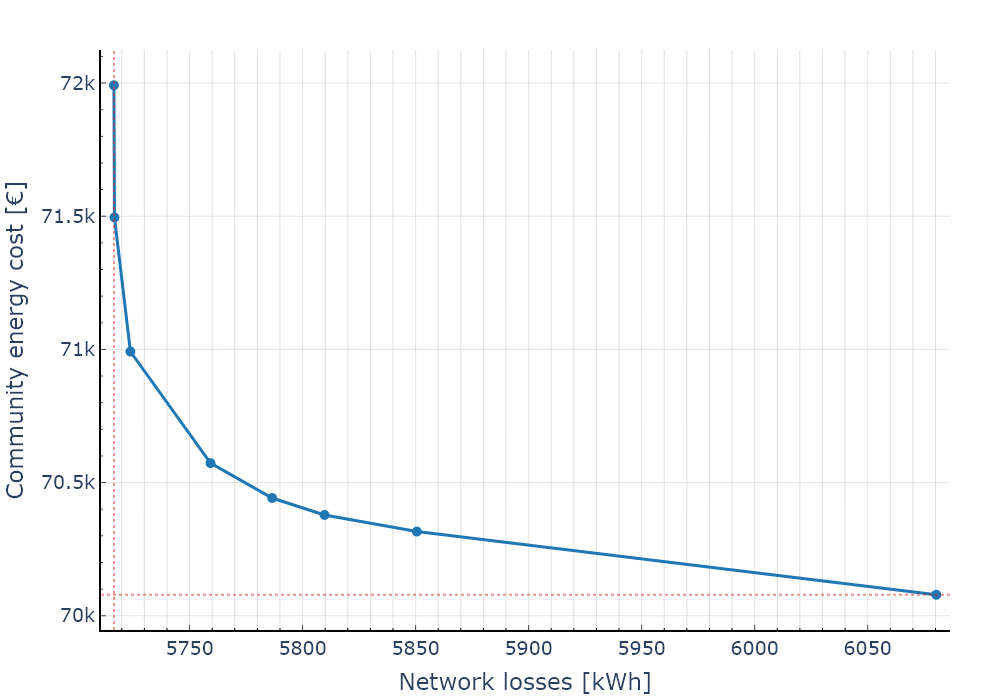

In [6]:
graph = study.summary.copy()
fig = px.line(graph, x="total_losses", y="actual_cost")
fig.data[0].update(mode="markers+lines")
fig.data[0].update(line_width=3, marker_size=10)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='rgba(127, 127, 127, 0.2)')
fig.update_xaxes(minor=dict(ticks="inside", ticklen=2, tickcolor="black", showgrid=True), ticks="inside", ticklen=5)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='rgba(127, 127, 127, 0.2)')
fig.update_yaxes(minor_ticks="inside", minor_ticklen=2, ticks="inside", ticklen=5)

fig.add_vline(x=fig.data[0].x[-1], line_dash="dot", opacity=0.5, line_color='#d62728')
fig.add_hline(y=fig.data[0].y[0], line_dash="dot", opacity=0.5, line_color='#d62728')

fig.update_layout(
    layout,
    height=700,
    width=1000,
    showlegend=False,
    yaxis_title="Community energy cost [€]",
    xaxis_range=[(1 - 1e-3) * graph.total_losses.min(), (1 + 1e-3) * graph.total_losses.max()],
    xaxis_title="Network losses [kWh]",
)

fig.show()
fig.write_image("results/tradeoff_col_reduc.svg")

In [7]:
study.summary

,actual_cost,total_losses,vm_above_percent,vm_below_percent,vm_square_error,max_upper_demand,max_back_feed
0,70078.835108,6080.334899,0.0,1.611149,0.307845,65.711747,-10.483908
1,70316.154197,5850.534021,0.0,0.469322,0.318952,47.492464,-5.721077
2,70378.484171,5809.703845,0.0,0.331960,0.313676,45.858022,-5.721012
3,70442.005102,5786.542058,0.0,0.269002,0.310927,44.588938,-5.719574
4,70573.087968,5759.261916,0.0,0.194597,0.307807,42.560855,-5.714896
5,70992.049492,5723.820053,0.0,0.080128,0.303419,38.284194,-5.689275
6,71495.497548,5716.778184,0.0,0.068681,0.302219,36.057084,-5.644956
7,71991.746429,5716.532758,0.0,0.068681,0.302094,35.810998,-5.642806


In [8]:
df_metric = pd.DataFrame(index=range(0, study.nb_tradeoffs + 2))
for i, result in enumerate(study.results):
    df_metric.loc[i, "actual_cost"] = result.loc[:, "actual_cost"].sum()
    df_metric.loc[i, "total_losses"] = result.loc[:, "total_losses"].sum()
    df_metric.loc[i, "vm_above_percent"] = result.loc[:, "vm_above_percent"].quantile(0.95)  # 5% of simulations --> 6 * 3j = 18j included
    df_metric.loc[i, "vm_below_percent"] = result.loc[:, "vm_below_percent"].quantile(0.95)
    # df_metric.loc[i, "vm_square_error"] = result.loc[:, "vm_square_error"].sum()
    df_metric.loc[i, "max_upper_demand"] = result.loc[:, "max_upper_demand"].quantile(0.95)
    df_metric.loc[i, "max_back_feed"] = result.loc[:, "max_back_feed"].quantile(0.05)
df_metric[["actual_cost", "total_losses", "vm_below_percent", "max_upper_demand", "max_back_feed"]].round(1)

,actual_cost,total_losses,vm_below_percent,max_upper_demand,max_back_feed
0,70078.8,6080.3,5.7,97.7,-29.8
1,70316.2,5850.5,1.6,87.6,-16.8
2,70378.5,5809.7,1.0,80.4,-16.8
3,70442.0,5786.5,1.0,75.9,-16.8
4,70573.1,5759.3,1.0,70.9,-16.7
5,70992.0,5723.8,0.5,64.3,-16.7
6,71495.5,5716.8,0.5,60.7,-16.6
7,71991.7,5716.5,0.5,59.9,-16.6


In [9]:
for _ in range(study.nb_tradeoffs + 2):
    mask = study.results[_].remove_battery_efficiency == False
    print(f"Split# {_} with efficiency = "
          f"{study.results[_][mask].remove_battery_efficiency.count() * 100 / len(study.results[_]):0.2f}%")

Split# 0 with efficiency = 100.00%
Split# 1 with efficiency = 47.25%
Split# 2 with efficiency = 47.25%
Split# 3 with efficiency = 47.25%
Split# 4 with efficiency = 47.25%
Split# 5 with efficiency = 47.25%
Split# 6 with efficiency = 47.25%
Split# 7 with efficiency = 47.25%


In [10]:
with open('results/tradeoff_ind_reduc.pickle', 'rb') as handle:
    ind_study = pickle.load(handle)

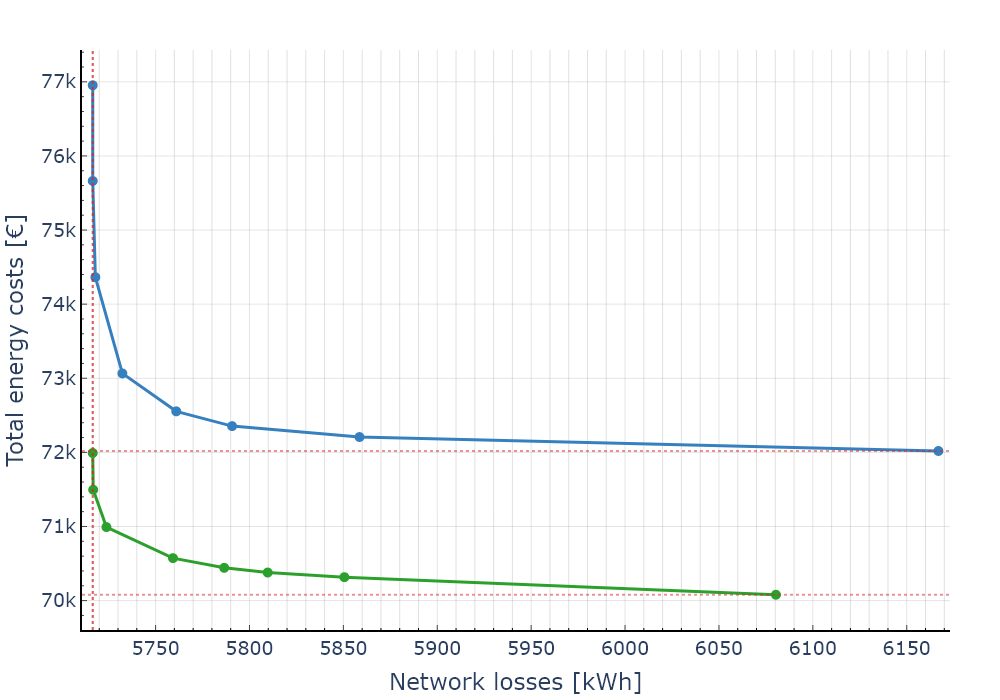

In [11]:
graph = study.summary.copy()
fig = px.line(graph, x="total_losses", y="actual_cost")
fig.data[0].update(mode="markers+lines")
fig.data[0].update(line_width=3, marker_size=10, line_color="rgba(44, 160, 44, 1.0)")

graph = ind_study.summary.copy()
fig.add_trace(px.line(graph, x="total_losses", y="actual_cost").data[0])
fig.data[1].update(mode="markers+lines")
fig.data[1].update(line_width=3, marker_size=10, line_color="rgba(55, 128, 191, 1.0)")

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='rgba(127, 127, 127, 0.2)')
fig.update_xaxes(minor=dict(ticks="inside", ticklen=2, tickcolor="black", showgrid=True), ticks="inside", ticklen=5)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='rgba(127, 127, 127, 0.2)')
fig.update_yaxes(minor_ticks="inside", minor_ticklen=2, ticks="inside", ticklen=5)

fig.add_vline(x=fig.data[0].x[-1], line_dash="dot", opacity=0.5, line_color='#d62728')
fig.add_hline(y=fig.data[0].y[0], line_dash="dot", opacity=0.5, line_color='#d62728')

fig.add_vline(x=fig.data[1].x[-1], line_dash="dot", opacity=0.5, line_color='#d62728')
fig.add_hline(y=fig.data[1].y[0], line_dash="dot", opacity=0.5, line_color='#d62728')

fig.update_layout(
    layout,
    height=700,
    width=1000,
    showlegend=False,
    yaxis_title="Total energy costs [€]",
    xaxis_range=[(1 - 1e-3) * graph.total_losses.min(), (1 + 1e-3) * graph.total_losses.max()],
    xaxis_title="Network losses [kWh]",
)

fig.show()
fig.write_image("results/tradeoff_col_ind_reduc.svg")